# Exercise 1

# 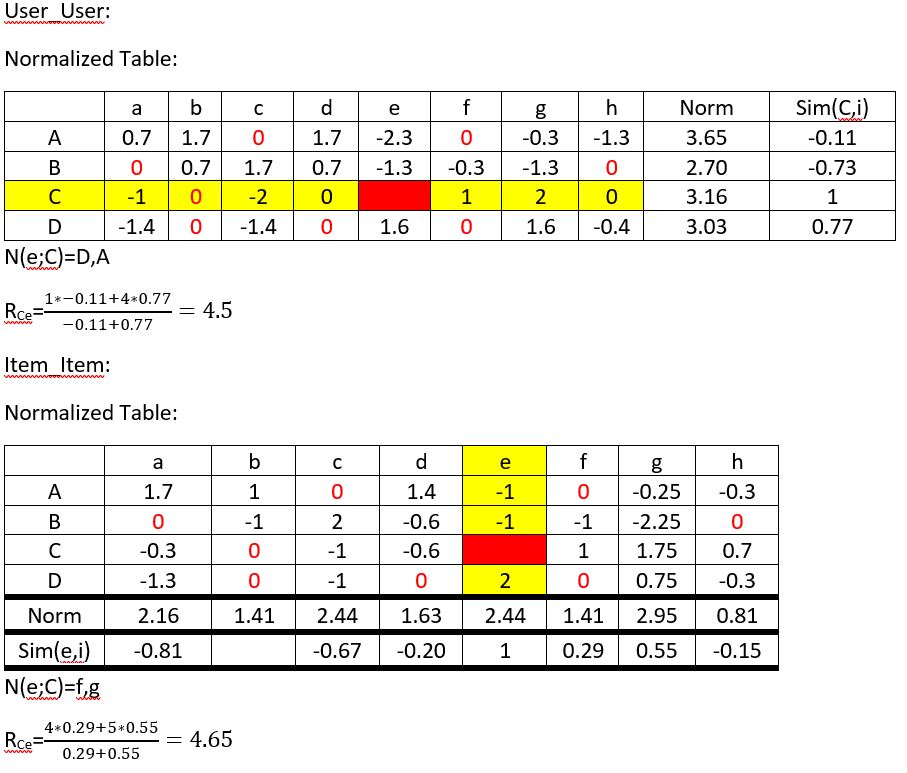

# Exercise 2

In [1]:
# Import statements
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import time

In [2]:
"""
Linear regression can be used to make predictions of a target variable with a set of predictor variables.
The forumla for predictions ^y^ is: ^y^ = X * w.
X is the matrix of m observations and each observation is composed of n predictor variables (thus X is m x n).
w is a vector of n weights (coefficients, thus w is n x 1)
"""
data = {
    'n_samples': 100,
    'n_features': 2,
    'noise': 3,
    'coef': True,
    'random_state': 742
}
x, y, coef = make_regression(**data)
# instantiate w with zeros at first. The gradient descent will update the weights iteratively
w = np.zeros(x.shape[1]).reshape(-1,1)
print(f'Type of x: {type(x)}, Dimension: {x.shape}')
print(f'Type of w: {type(w)}, Dimension: {w.shape}')
print(f'Type of y: {type(y)}, Dimension: {y.reshape(-1,1).shape}')

Type of x: <class 'numpy.ndarray'>, Dimension: (100, 2)
Type of w: <class 'numpy.ndarray'>, Dimension: (2, 1)
Type of y: <class 'numpy.ndarray'>, Dimension: (100, 1)


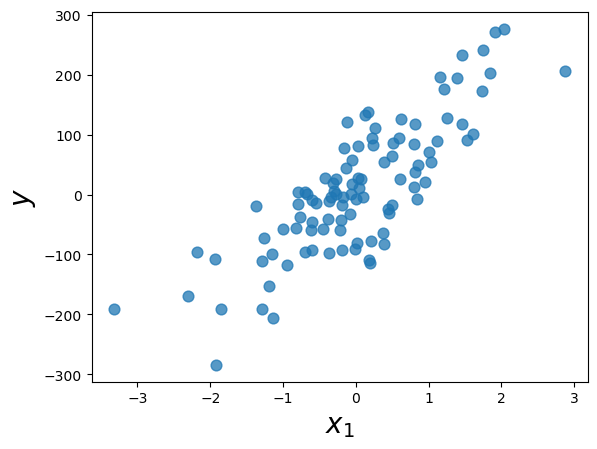

In [3]:
plt.scatter(x[:, 0], y, alpha=0.75, s=60)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()

In [5]:
# use mean squared error as loss function for linear regression
def mse(x, y, w):
    return ((y - np.dot(x, w))**2).mean()
    
def mse_gradient(x, y, w):
    residual = y - np.dot(x, w)
    return (-2/x.shape[0]) * np.dot(x.T, residual)

In [6]:
# make n_iters updates to w with a constant learning_rate
def gradient_descent(x, y, learning_rate=0.1, n_iters=100):
    w = np.zeros(x.shape[1])
    for i in range(n_iters):
        w_gradient = mse_gradient(x, y, w)
        w = w - learning_rate*w_gradient
    return w

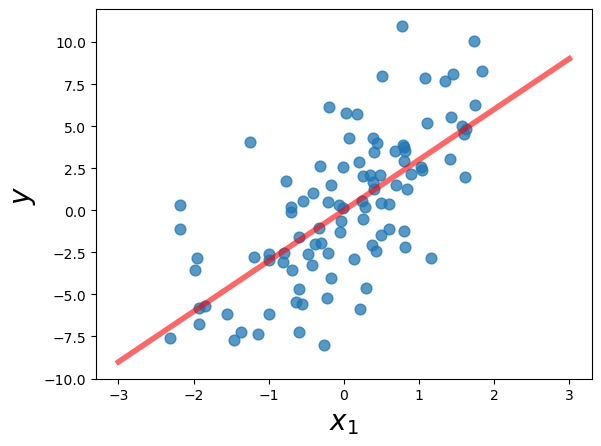

The gradient descent converged on w = 3.0048.
Scikit-Learn used w = 3.0549 to generate the data.


In [7]:
# verify that algorithm works correctly
# for showcasing reasons, reduce the number of features 
data.update({'n_features': 1})
x, y, coef = make_regression(**data)
w = gradient_descent(x, y)

# plot the data
plt.scatter(x[:, 0], y, alpha=0.75, s=60)
xx = np.linspace(-3, 3, 100).reshape(-1, 1)
yy = np.dot(xx, w)
plt.plot(xx, yy, c='r', lw=4, alpha=0.6)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()
print(f"The gradient descent converged on w = {round(w.item(), 4)}.")
print(f"Scikit-Learn used w = {round(coef.item(), 4)} to generate the data.")

In [8]:
# test run for bigger dimension
data.update({
    'n_features': 5,
    'n_samples': 10000
})
x, y, coef = make_regression(**data)
w = gradient_descent(x, y)

print(f'Using feature size [{data["n_features"]}] and sample size [{data["n_samples"]}]')
print(f"The gradient descent converged on" 
      f"\n w = {w}.")
print(f"Scikit-Learn used "
      f"\n w = {coef} to generate the data.")

Using feature size [5] and sample size [10000]
The gradient descent converged on
 w = [96.72515793 93.00955702 64.63310238 51.45764147  1.81664216].
Scikit-Learn used 
 w = [96.70810988 93.00545673 64.63388272 51.48150842  1.81941553] to generate the data.


# Exercise 3

In [1]:
# Import modules
from pyspark.mllib.recommendation import ALS, Rating, MatrixFactorizationModel
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os
from IPython.display import clear_output
#from pyspark.sql.types import StructType,StructField, StringType, IntegerType,DoubleType

In [2]:
# Create PySpark Session
_conf = SparkConf()
_conf.set('spark.driver.host', '127.0.0.1')
_conf.set('log.level', 'ERROR')
_cpu_count = os.cpu_count()
sc = SparkContext(master=f"local[{_cpu_count}]",
                  appName="Exercise 03",
                  conf=_conf).getOrCreate()
sc.setLogLevel('ERROR')
clear_output()
spark = SparkSession(sc)

In [3]:
# Read in the ratings data
lines = sc.textFile("movielens.txt")

def parseLine(line):
    fields = line.split("\t")
    return Rating(int(fields[0]), int(fields[1]), float(fields[2]))
ratings = lines.map(lambda r: parseLine(r))

#split to train and test
rdd_train, rdd_test = ratings.randomSplit([0.5, 0.5], 17)

# Train a model on to predict user-product ratings
model = ALS.train(rdd_train,rank= 10)


# Get predicted ratings on test set user-product pairs
testData = rdd_test.map(lambda p: (p.user, p.product))
predictions = model.predictAll(testData).map(lambda r: ((r.user, r.product), r.rating))

ratingsTuple = ratings.map(lambda r: ((r.user, r.product), r.rating))
scoreAndLabels = predictions.join(ratingsTuple).map(lambda tup: tup[1])

# Instantiate regression metrics to compare predicted and actual ratings
metrics = RegressionMetrics(scoreAndLabels)

# mean sqaured error
#print("RMSE = %s" % metrics.rootMeanSquaredError)
print("MSE = %s" % metrics.meanSquaredError)

/home/raichuu/miniconda3/envs/pyspark/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE = 1.4255782707289324


In [5]:
# Save the model
model.save(sc, 'e3-model')
sameModel = MatrixFactorizationModel.load(sc, 'e3-model')

# Exercise 4.a

In [1]:
import numpy

def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = numpy.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
            
    

    return P, Q.T
if __name__ == "__main__":
    R = [
         [1,0,3,0,0,5,0,0,5,0,4,0],
         [0,0,5,4,0,0,4,0,0,2,1,3],
         [2,4,0,1,2,0,3,0,4,3,5,0],
         [0,2,4,0,5,0,0,4,0,0,2,0],
         [0,0,4,3,4,2,0,0,0,0,2,5],
         [1,0,3,0,3,0,0,2,0,0,4,0]
        ]

    R = numpy.array(R)

    N = len(R)
    M = len(R[0])
    K = 2

    P = numpy.random.rand(N,K)
    Q = numpy.random.rand(M,K)

    nP, nQ = matrix_factorization(R, P, Q, K)
    nR = numpy.dot(nP, nQ.T) 
   
    print (nR)

[[ 1.15535028  3.54386539  3.09063247  2.41486625  3.616269    4.75835826
   4.21448214  2.8079163   4.8976195   3.30358766  4.22191606  4.6854565 ]
 [-0.60520004  0.68686594  4.54036445  3.73076256  4.47541738  0.71833312
   3.99086754  3.50677177  3.57670137  1.97644232  0.6936124   3.73414225]
 [ 1.78377588  4.03241259  1.2865358   0.90160288  1.97903107  5.52971983
   2.99949486  1.51868594  4.08607815  3.00296812  4.87448166  3.73231303]
 [ 0.03540559  1.93142215  4.50930823  3.65461744  4.67621304  2.44716671
   4.5718462   3.65368821  4.55241254  2.7581332   2.21160579  4.57909914]
 [ 0.0529688   1.793036    4.09066943  3.31366861  4.24965975  2.27677112
   4.16732819  3.32008282  4.1625371   2.52812197  2.05616686  4.18249801]
 [ 1.07437536  3.18555504  2.60778142  2.02967386  3.08748337  4.28606858
   3.6511694   2.3959587   4.28886235  2.91181576  3.80043889  4.08956765]]


# Exercise 4.b

In [2]:
import numpy
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = numpy.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
            
        print ('step',step,'error:',e)
        step += 1

    return P, Q.T
if __name__ == "__main__":
    R = [
         [1,0,3,0,0,5,0,0,5,0,4,0],
         [0,0,5,4,0,0,4,0,0,2,1,3],
         [2,4,0,1,2,0,3,0,4,3,5,0],
         [0,2,4,0,5,0,0,4,0,0,2,0],
         [0,0,4,3,4,2,0,0,0,0,2,5],
         [1,0,3,0,3,0,0,2,0,0,4,0]
        ]

    R = numpy.array(R)

    N = len(R)
    M = len(R[0])
    K = 2

    P = numpy.random.rand(N,K)
    Q = numpy.random.rand(M,K)

    nP, nQ = matrix_factorization(R, P, Q, K)
    nR = numpy.dot(nP, nQ.T) 
   
    print (nR)

step 0 error: 328.67678184958197
step 1 error: 327.7435540701887
step 2 error: 326.80516423940554
step 3 error: 325.86160711082874
step 4 error: 324.9128784382159
step 5 error: 323.9589749898474
step 6 error: 322.9998945628187
step 7 error: 322.03563599725874
step 8 error: 321.0661991904568
step 9 error: 320.0915851108929
step 10 error: 319.1117958121572
step 11 error: 318.126834446749
step 12 error: 317.13670527973994
step 13 error: 316.1414137022942
step 14 error: 315.14096624503065
step 15 error: 314.13537059121427
step 16 error: 313.1246355897678
step 17 error: 312.1087712680868
step 18 error: 311.08778884464834
step 19 error: 310.06170074139754
step 20 error: 309.03052059590476
step 21 error: 307.99426327327
step 22 error: 306.9529448777724
step 23 error: 305.9065827642448
step 24 error: 304.85519554915726
step 25 error: 303.79880312140676
step 26 error: 302.73742665278513
step 27 error: 301.6710886081233
step 28 error: 300.59981275508886
step 29 error: 299.52362417363184
step 30 

step 815 error: 19.62832399288417
step 816 error: 19.604992995661163
step 817 error: 19.58169253802388
step 818 error: 19.558422616821836
step 819 error: 19.535183229611565
step 820 error: 19.511974374644137
step 821 error: 19.488796050852876
step 822 error: 19.465648257841206
step 823 error: 19.442530995870484
step 824 error: 19.41944426584807
step 825 error: 19.396388069315446
step 826 error: 19.373362408436424
step 827 error: 19.35036728598555
step 828 error: 19.3274027053365
step 829 error: 19.304468670450643
step 830 error: 19.281565185865713
step 831 error: 19.258692256684576
step 832 error: 19.235849888564054
step 833 error: 19.21303808770397
step 834 error: 19.190256860836126
step 835 error: 19.16750621521351
step 836 error: 19.144786158599608
step 837 error: 19.12209669925767
step 838 error: 19.099437845940272
step 839 error: 19.076809607878864
step 840 error: 19.05421199477333
step 841 error: 19.03164501678179
step 842 error: 19.009108684510608
step 843 error: 18.986603009004

step 1621 error: 10.112631922197755
step 1622 error: 10.10867175738549
step 1623 error: 10.104719931981291
step 1624 error: 10.100776417998867
step 1625 error: 10.096841187544719
step 1626 error: 10.092914212817972
step 1627 error: 10.088995466110175
step 1628 error: 10.08508491980511
step 1629 error: 10.081182546378542
step 1630 error: 10.077288318398084
step 1631 error: 10.073402208522943
step 1632 error: 10.069524189503722
step 1633 error: 10.065654234182254
step 1634 error: 10.061792315491356
step 1635 error: 10.057938406454657
step 1636 error: 10.054092480186323
step 1637 error: 10.05025450989095
step 1638 error: 10.046424468863302
step 1639 error: 10.042602330488082
step 1640 error: 10.038788068239771
step 1641 error: 10.034981655682397
step 1642 error: 10.031183066469335
step 1643 error: 10.027392274343049
step 1644 error: 10.023609253134984
step 1645 error: 10.019833976765238
step 1646 error: 10.016066419242433
step 1647 error: 10.012306554663484
step 1648 error: 10.00855435721

step 2426 error: 8.270729698726726
step 2427 error: 8.269242334558337
step 2428 error: 8.267755909414083
step 2429 error: 8.266270421551893
step 2430 error: 8.264785869234613
step 2431 error: 8.263302250730058
step 2432 error: 8.26181956431093
step 2433 error: 8.260337808254832
step 2434 error: 8.25885698084424
step 2435 error: 8.257377080366519
step 2436 error: 8.255898105113832
step 2437 error: 8.254420053383205
step 2438 error: 8.252942923476452
step 2439 error: 8.25146671370019
step 2440 error: 8.249991422365792
step 2441 error: 8.248517047789393
step 2442 error: 8.247043588291893
step 2443 error: 8.245571042198867
step 2444 error: 8.244099407840624
step 2445 error: 8.242628683552168
step 2446 error: 8.24115886767315
step 2447 error: 8.239689958547894
step 2448 error: 8.238221954525352
step 2449 error: 8.236754853959093
step 2450 error: 8.235288655207295
step 2451 error: 8.23382335663274
step 2452 error: 8.23235895660275
step 2453 error: 8.230895453489227
step 2454 error: 8.2294328

step 3231 error: 7.280399887896849
step 3232 error: 7.279348931926857
step 3233 error: 7.2782982925691435
step 3234 error: 7.277247969509877
step 3235 error: 7.276197962435758
step 3236 error: 7.275148271034047
step 3237 error: 7.2740988949925445
step 3238 error: 7.273049833999606
step 3239 error: 7.2720010877441235
step 3240 error: 7.270952655915551
step 3241 error: 7.269904538203872
step 3242 error: 7.268856734299597
step 3243 error: 7.267809243893825
step 3244 error: 7.26676206667816
step 3245 error: 7.26571520234475
step 3246 error: 7.264668650586288
step 3247 error: 7.263622411096015
step 3248 error: 7.262576483567688
step 3249 error: 7.261530867695627
step 3250 error: 7.2604855631746625
step 3251 error: 7.2594405697001765
step 3252 error: 7.258395886968082
step 3253 error: 7.257351514674819
step 3254 error: 7.256307452517363
step 3255 error: 7.255263700193232
step 3256 error: 7.254220257400454
step 3257 error: 7.253177123837606
step 3258 error: 7.2521342992037665
step 3259 error:

step 4064 error: 6.493191437261217
step 4065 error: 6.492334979442122
step 4066 error: 6.491478707430881
step 4067 error: 6.490622621175702
step 4068 error: 6.489766720624957
step 4069 error: 6.488911005727178
step 4070 error: 6.488055476431048
step 4071 error: 6.487200132685399
step 4072 error: 6.486344974439232
step 4073 error: 6.485490001641679
step 4074 error: 6.484635214242041
step 4075 error: 6.483780612189786
step 4076 error: 6.4829261954345005
step 4077 error: 6.48207196392595
step 4078 error: 6.481217917614046
step 4079 error: 6.480364056448853
step 4080 error: 6.47951038038058
step 4081 error: 6.478656889359593
step 4082 error: 6.477803583336422
step 4083 error: 6.476950462261724
step 4084 error: 6.476097526086319
step 4085 error: 6.475244774761186
step 4086 error: 6.47439220823743
step 4087 error: 6.473539826466343
step 4088 error: 6.472687629399332
step 4089 error: 6.471835616987969
step 4090 error: 6.470983789183978
step 4091 error: 6.470132145939219
step 4092 error: 6.469

step 4876 error: 5.856393430388421
step 4877 error: 5.855680251360403
step 4878 error: 5.854967246606905
step 4879 error: 5.854254416131398
step 4880 error: 5.853541759937368
step 4881 error: 5.852829278028306
step 4882 error: 5.8521169704077165
step 4883 error: 5.851404837079093
step 4884 error: 5.850692878045944
step 4885 error: 5.849981093311802
step 4886 error: 5.849269482880184
step 4887 error: 5.84855804675462
step 4888 error: 5.84784678493865
step 4889 error: 5.847135697435818
step 4890 error: 5.846424784249671
step 4891 error: 5.845714045383768
step 4892 error: 5.845003480841677
step 4893 error: 5.844293090626954
step 4894 error: 5.843582874743191
step 4895 error: 5.8428728331939555
step 4896 error: 5.842162965982839
step 4897 error: 5.84145327311344
step 4898 error: 5.8407437545893375
step 4899 error: 5.84003441041416
step 4900 error: 5.839325240591498
step 4901 error: 5.838616245124975
step 4902 error: 5.837907424018205
step 4903 error: 5.837198777274815
step 4904 error: 5.83

# Exercise 5.a

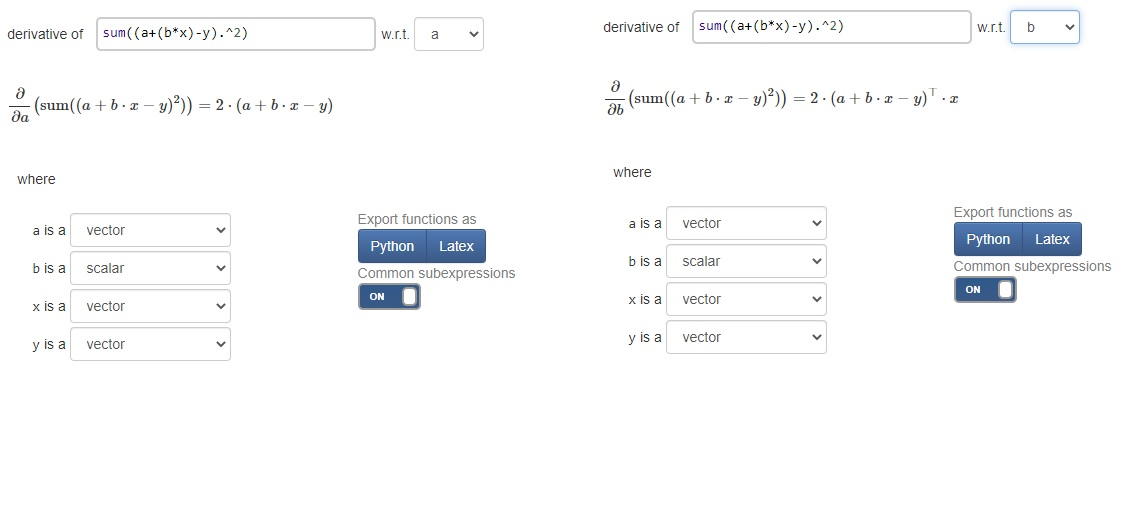# 

# Exercise 5.b

# 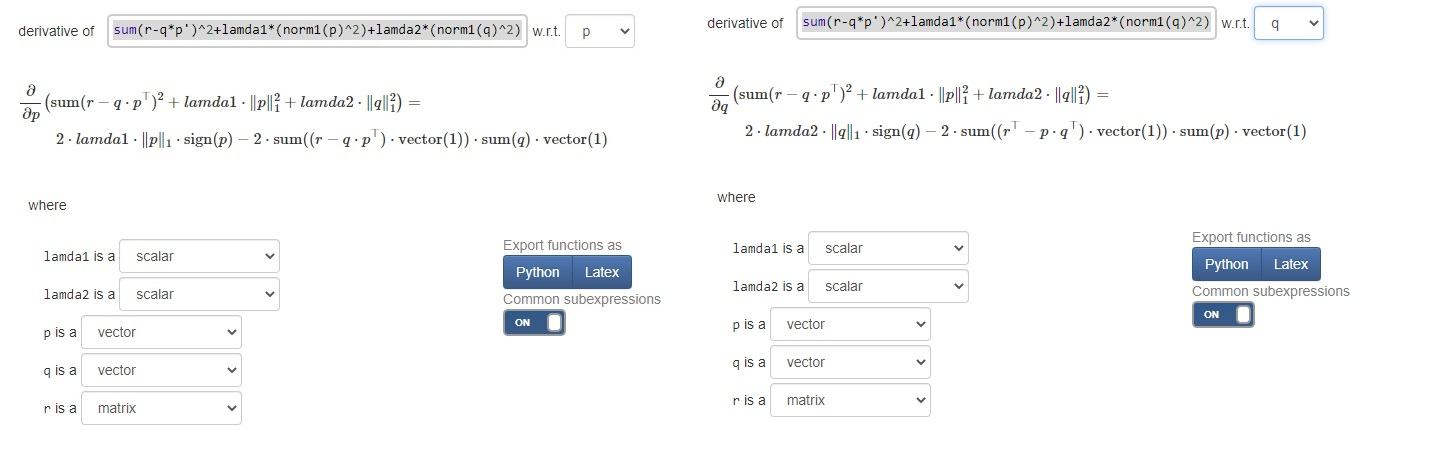

# Exercise 6.b

# Exercise 6.c

"Gray sheep" and "black sheep" might be useful for collabrating filtering, by eenhance the accuracy of prediction and turning the users whose preferences disagree with the target user, into new similar neighbors. For instance, if a user X is dissimilar to a user Y then the user ¬ X is similar to the user Y.